# MPC: SOCP EHv2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp
import os

from EnergyHub.env_EH_v2 import EHv2
from MPC.agent_mpc_det_week import MPCdetv0week
from MPC.agent_mpc_stoch_v1week import MPCstochv2week
from MPC.agent_mpc_stoch_rec_v1week import MPCstochv3week

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [3]:
resFolder = "Results"
if not os.path.exists(resFolder):
    os.makedirs(resFolder)

In [4]:
n_episodes_per_season_test = 4 # 70
n_days_per_episode_test = 1
alphas_test = [0.1]
saveVarsEnvAgent_plot = True
e_plot = 11 # 4 11 82
print(f'Select start date at SeasonId={int(e_plot/n_episodes_per_season_test)}, SeasonEpId={e_plot%n_episodes_per_season_test}')

Select start date at SeasonId=2, SeasonEpId=3


In [5]:
start_date_plot = pd.to_datetime('2021-07-04') # corresponds to: SeasonId=2, SeasonEpId=3
dt_eplot = pd.date_range(start=start_date_plot, periods=96*(n_days_per_episode_test+1), freq='15min')
tick_locs = np.arange(13, 96*(n_days_per_episode_test+1), 36)

In [6]:
scale_bat = 1
battery_config_opt_v4 = {
    'E_b_0': 0.25, # E_b[0] = E_b_0 * E_b_max
    'E_b_max': 90 * scale_bat, # kWh
    'E_b_min': 10 * scale_bat, # kWh
    'splines': np.array( # Single module battery scaled to 100kWh E_b
        [[ 63.47144295, 205.10911485], 
        [ 24.59458176, 360.84085873],
        [ 15.11269669, 459.47458218],
        [ 11.23026708, 517.65138388]]
        ) * scale_bat
        }

In [7]:
plot_power_max = 150 #* env.scale_pv
plot_power_min = -75 #* env.scale_pv
plot_grid_max = 125 * scale_bat
plot_grid_min = -175 * scale_bat 
plot_bat_max = 125 * scale_bat
plot_bat_min = -150 * scale_bat

## MPC Omniscient

In [8]:
agent_config_omn = {
    'version': 'MPComn',
    'alphas': [],
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1, 
}

### problem formulation

In [9]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_plot
env = EHv2(battery_config=battery_config_opt_v4, agent_config=agent_config_omn, do_save_env_vars=do_save_env)
agent = MPCdetv0week(env=env, agent_config=agent_config_omn, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
emission_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
emission_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('------------------------------ EpisodeId: %r (SeasonId: %r, SeasonEpId: %r) ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCdetv0week(env=env, agent_config=agent_config_omn, do_save_agent_vars=do_save_agent)
    episode_reward = episode_emissions = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, done, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = f" P_b({env.time_k - 1}): {a:.1f}  E_b({env.time_k}): {obs:.1f}  Cost_g({env.time_k - 1}): {rew[0]:.3f} Emission_g({env.time_k - 1}): {rew[1]:.3f}"
            print(mssg)
        episode_reward += rew[0]
        episode_emissions += rew[1]

    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    emission_all[e] = episode_emissions
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save
        emission_actual_all[e] = env.emission_actual_save


/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/env_EH_v2.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  self.prob_array = np.array([1 / self.n_scenarios] * self.n_scenarios)


------------------------------ EpisodeId: 0 (SeasonId: 0, SeasonEpId: 0) ------------------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-28


/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/utils.py:142: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])
/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/utils.py:142: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])
/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/utils.py:142: FutureWarning: The behavior of ar

------------------------------ EpisodeId: 1 (SeasonId: 0, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 2 (SeasonId: 0, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 3 (SeasonId: 0, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 4 (SeasonId: 1, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 5 (SeasonId: 1, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 6 (SeasonId: 1, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 7 (SeasonId: 1, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 8 (SeasonId: 2, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 9 (SeasonId: 2, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 10 (SeasonId: 2, Seaso

### plot results

In [10]:
reward_all_det_omn = reward_all
emission_all_det_omn = emission_all

In [11]:
e = e_plot
reward_all_det_omn[e], emission_all_det_omn[e]

(np.float64(-10.275429332950619), np.float64(8.088661824234212))

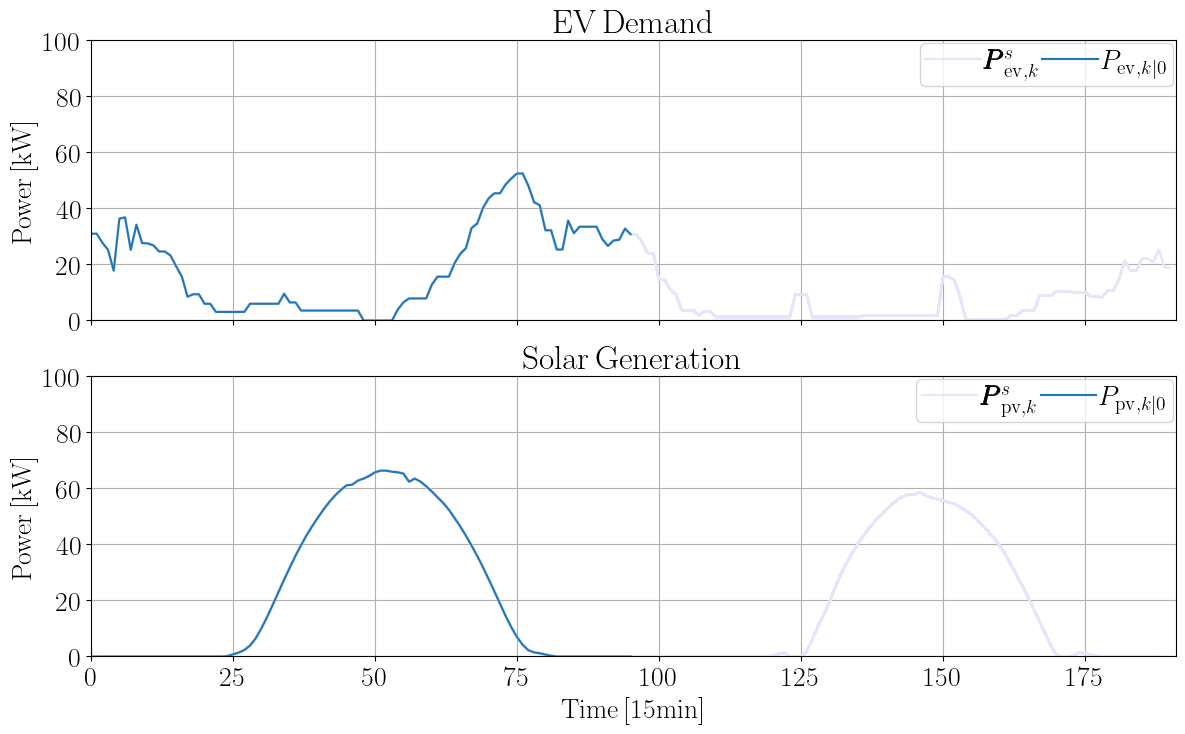

In [12]:
plot_max = 100

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{ev}, k}^s$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, k|0}$')
    ax[0].set_title(r'$\mathrm{EV\, Demand}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in p_pv_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{pv}, k}^s$')
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA', ) 

    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{pv}, k|0}$')
    ax[1].set_title(r'$\mathrm{Solar \, Generation}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

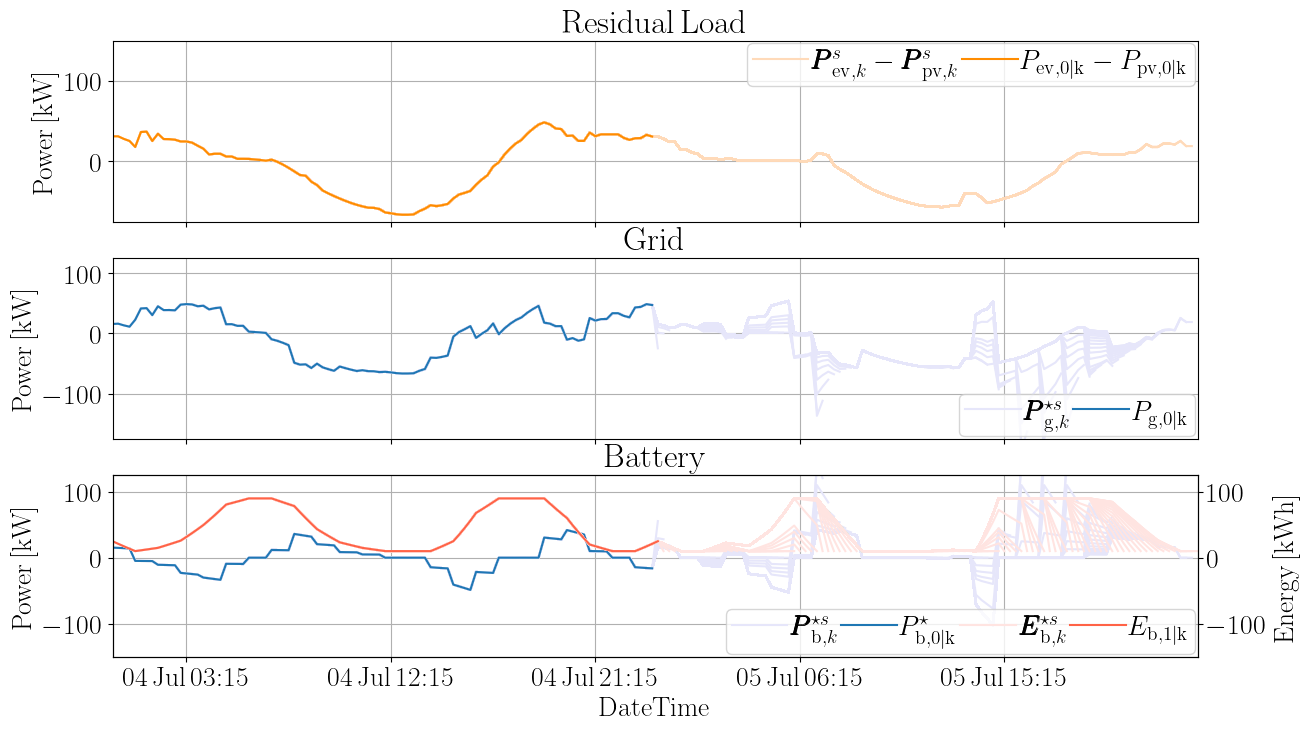

In [13]:
if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#FFDAB9', label=r'$\pmb{P}_{\mathrm{ev}, k}^s - \pmb{P}_{\mathrm{pv}, k}^s$')
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_\mathrm{ev, 0|k} - P_\mathrm{pv, 0|k}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])
    ax[0].set_xticks(tick_locs)

    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{g}, k}^{\star s}$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_\mathrm{g, 0|k}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])
    ax[1].set_xticks(tick_locs)

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{b}, k}^{\star s}$')
        else:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', ) 

    ax[2].plot(dt_eplot[0:len(action_real)], action_real_all[e], label=r'$P_\mathrm{b, 0|k}^\star$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose', label=r'$\pmb{E}_{\mathrm{b}, k}^{\star s}$')
            
        else:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose')

    ax[2].plot(dt_eplot[0:len(E_b_real)], E_b_real_all[e], label=r'$E_\mathrm{b, 1|k}$', color='tomato') # check E_b
    ax2_battery = ax[2].twinx()
    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{DateTime}$')
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    ax[2].set_xlim(dt_eplot.min(), dt_eplot.max())
    ax[2].set_xticks(dt_eplot[tick_locs])
    ax[2].set_xticklabels([dt.strftime(r'$%d\mathrm{\,%b\,} %H\mathord{:}%M$') for dt in dt_eplot[tick_locs]], ha='center')

    # fig.savefig(f'{resFolder}/MPCOmn_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCOmn_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

### main plot

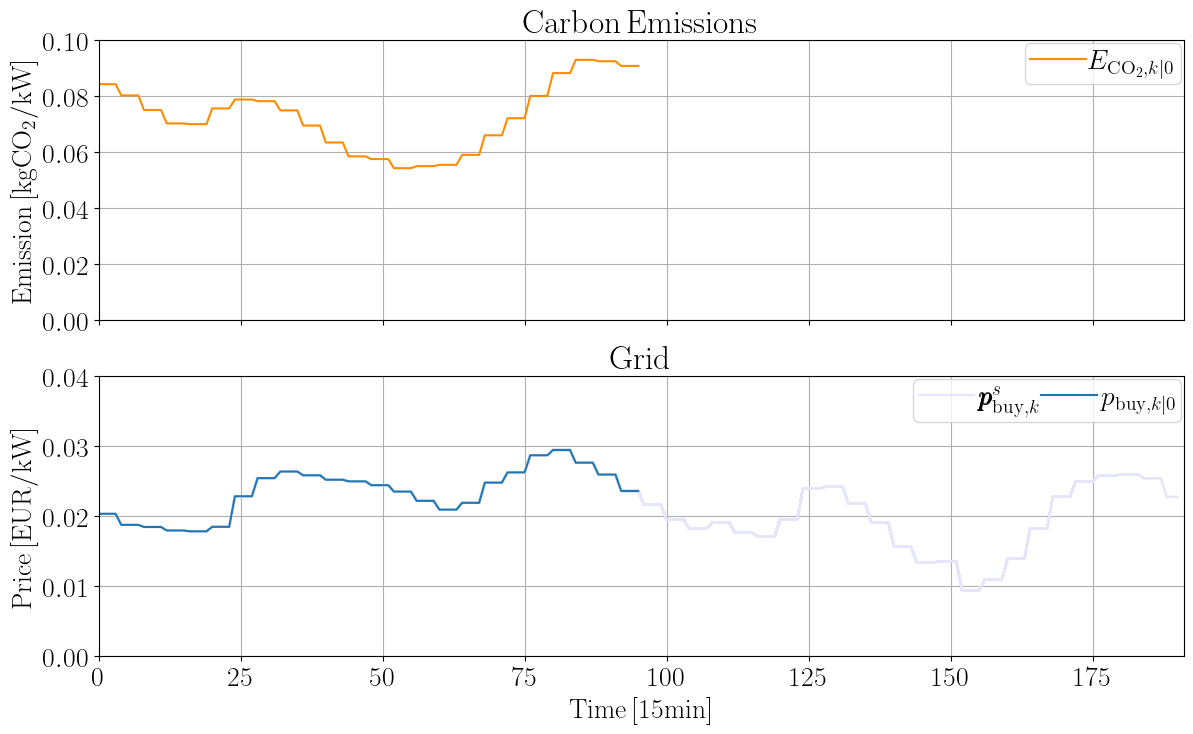

In [14]:
plot_p_max = 0.02 * 2
plot_em_max = 0.02 * 5

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(emission_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$E_{\mathrm{CO_2}, k|0}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Carbon\, Emissions}$')
    ax[0].set_ylabel(r'$\mathrm{Emission \, [kg \mathrm{CO}_2 / kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_em_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in price_buy_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:], color='#E6E6FA', label=r'$\pmb{p}_{\mathrm{buy}, k}^s$')
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA', ) 

    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$p_{\mathrm{buy}, k|0}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Price \, [EUR/kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_p_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()

    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

## MPC Vanilla

### problem formulation

In [15]:
agent_config_det = {
    'version': 'MPCdetv0',
    'alphas': [],
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1, 
}

In [16]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_plot
env = EHv2(battery_config=battery_config_opt_v4, agent_config=agent_config_det, do_save_env_vars=do_save_env)
agent = MPCdetv0week(env=env, agent_config=agent_config_det, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
emission_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
emission_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('------------------------------ EpisodeId: %r (SeasonId: %r, SeasonEpId: %r) ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCdetv0week(env=env, agent_config=agent_config_det, do_save_agent_vars=do_save_agent)
    episode_reward = episode_emissions = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, done, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = f" P_b({env.time_k - 1}): {a:.1f}  E_b({env.time_k}): {obs:.1f}  Cost_g({env.time_k - 1}): {rew[0]:.3f} Emission_g({env.time_k - 1}): {rew[1]:.3f}"
            print(mssg)
        episode_reward += rew[0]
        episode_emissions += rew[1]
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    emission_all[e] = episode_emissions
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save
        emission_actual_all[e] = env.emission_actual_save


/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/env_EH_v2.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  self.prob_array = np.array([1 / self.n_scenarios] * self.n_scenarios)
/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/utils.py:142: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season + 1)])
/Users/diego/VSCode/ChargingEnergyHubs_MPC/Control/EnergyHub/utils.py:142: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eva

------------------------------ EpisodeId: 0 (SeasonId: 0, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 1 (SeasonId: 0, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 2 (SeasonId: 0, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 3 (SeasonId: 0, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 4 (SeasonId: 1, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 5 (SeasonId: 1, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 6 (SeasonId: 1, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 7 (SeasonId: 1, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 8 (SeasonId: 2, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 9 (SeasonId: 2, Season

### plot results

In [24]:
reward_all_det_van = reward_all
emission_all_det_van = emission_all

In [25]:
e = e_plot
reward_all_det_van[e], emission_all_det_van[e]

(np.float64(-9.01329182300438), np.float64(13.304600762772719))

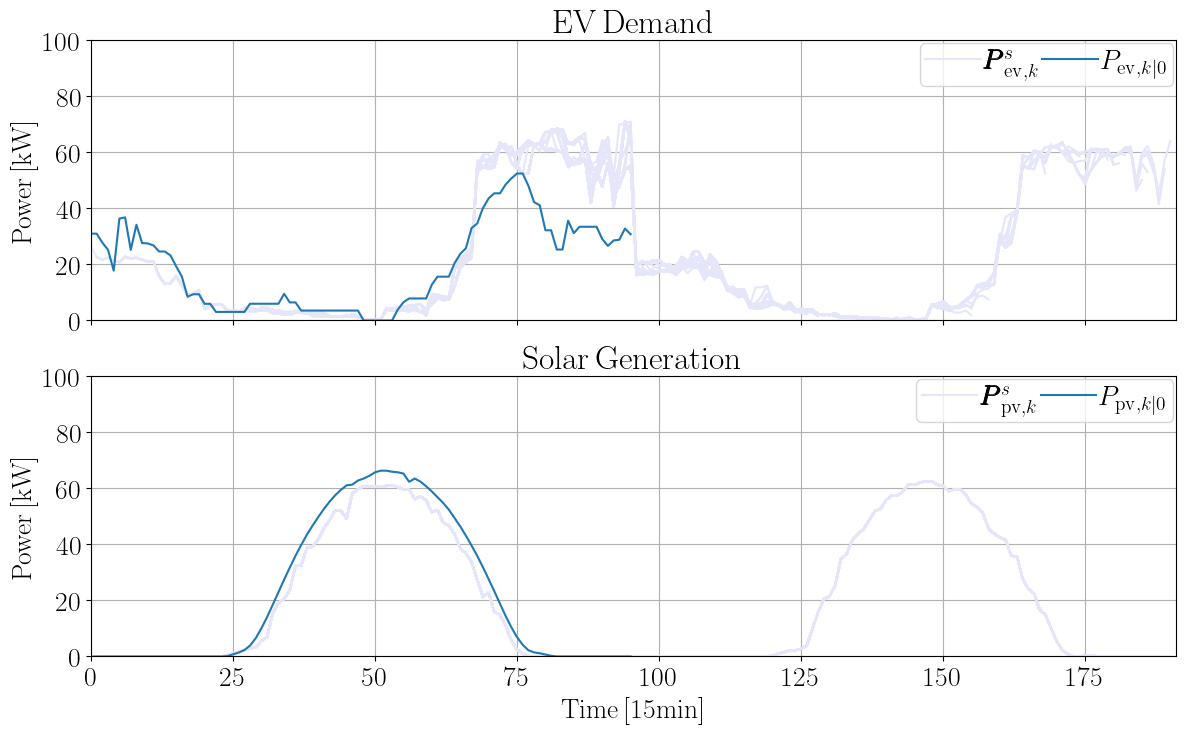

In [26]:
plot_max = 100

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{ev}, k}^s$')
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, k|0}$')
    ax[0].set_title(r'$\mathrm{EV\, Demand}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in p_pv_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{pv}, k}^s$')
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA', ) 

    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{pv}, k|0}$')
    ax[1].set_title(r'$\mathrm{Solar \, Generation}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

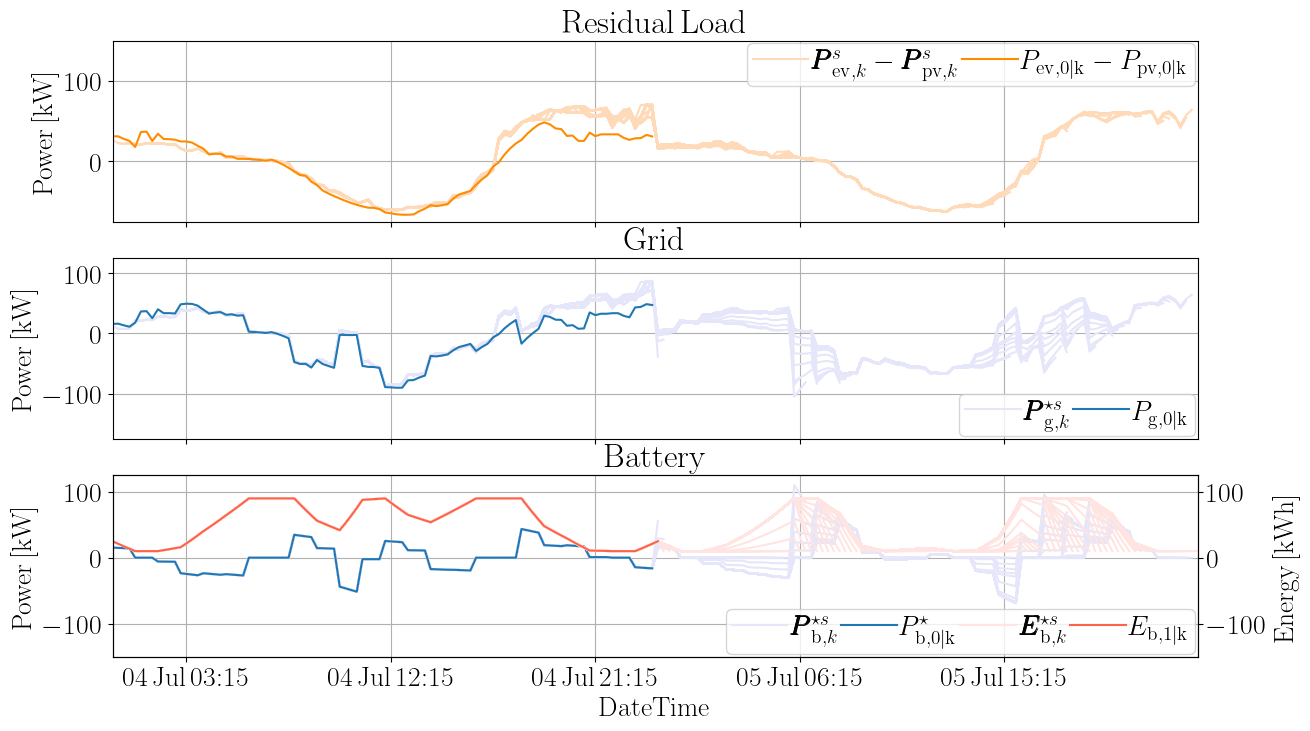

In [27]:
if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:], color='#FFDAB9', label=r'$\pmb{P}_{\mathrm{ev}, k}^s - \pmb{P}_{\mathrm{pv}, k}^s$')
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], 
               label=r'$P_\mathrm{ev, 0|k} - P_\mathrm{pv, 0|k}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])
    ax[0].set_xticks(tick_locs)

    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{g}, k}^{\star s}$')
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
            
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_\mathrm{g, 0|k}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])
    ax[1].set_xticks(tick_locs)

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{b}, k}^{\star s}$')
        else:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', ) 

    ax[2].plot(dt_eplot[0:len(action_real)], action_real_all[e], label=r'$P_\mathrm{b, 0|k}^\star$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose', label=r'$\pmb{E}_{\mathrm{b}, k}^{\star s}$')
            
        else:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose')

    ax[2].plot(dt_eplot[0:len(E_b_real)], E_b_real_all[e], label=r'$E_\mathrm{b, 1|k}$', color='tomato') # check E_b
    ax2_battery = ax[2].twinx()
    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)
    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{DateTime}$')
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    ax[2].set_xlim(dt_eplot.min(), dt_eplot.max())
    ax[2].set_xticks(dt_eplot[tick_locs])
    ax[2].set_xticklabels([dt.strftime(r'$%d\mathrm{\,%b\,} %H\mathord{:}%M$') for dt in dt_eplot[tick_locs]], ha='center')

    # fig.savefig(f'{resFolder}/MPCVan_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCVan_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

### main plot

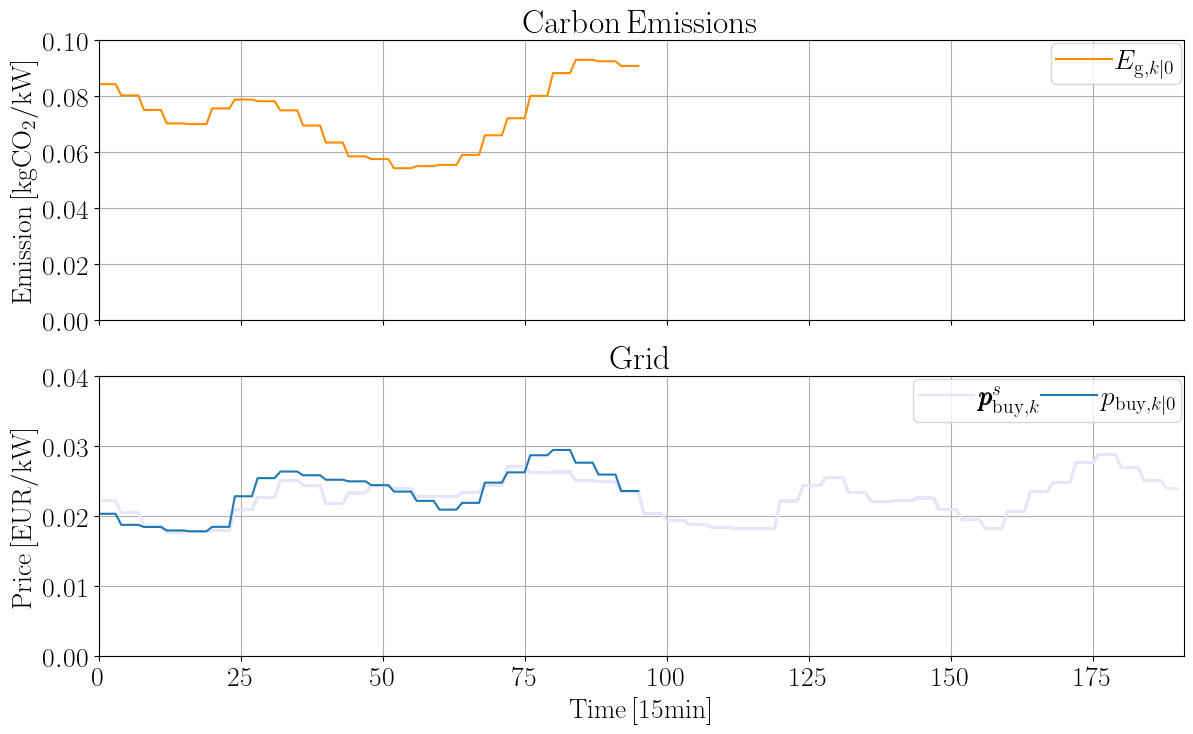

In [28]:
plot_p_max = 0.02 * 2
plot_em_max = 0.02 * 5

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(emission_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$E_{\mathrm{g}, k|0}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Carbon\, Emissions}$')
    ax[0].set_ylabel(r'$\mathrm{Emission \, [kg \mathrm{CO}_2 / kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_em_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in price_buy_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:], color='#E6E6FA', label=r'$\pmb{p}_{\mathrm{buy}, k}^s$')
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA', ) 

    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$p_{\mathrm{buy}, k|0}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Price \, [EUR/kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_p_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()

    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

## MPC Scenario

In [29]:
agent_config_stoch = {
    'version': 'MPCstochv2',
    'alphas': alphas_test,
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1, 
}

In [30]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_plot
env = EHv2(battery_config=battery_config_opt_v4, agent_config=agent_config_stoch, do_save_env_vars=do_save_env)
agent = MPCstochv2week(env=env, agent_config=agent_config_stoch, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
emission_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
emission_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('------------------------------ EpisodeId: %r (SeasonId: %r, SeasonEpId: %r) ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCstochv2week(env=env, agent_config=agent_config_stoch, do_save_agent_vars=do_save_agent)
    episode_reward = episode_emissions = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, done, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = f" P_b({env.time_k - 1}): {a:.1f}  E_b({env.time_k}): {obs:.1f}  Cost_g({env.time_k - 1}): {rew[0]:.3f} Emission_g({env.time_k - 1}): {rew[1]:.3f}"
            print(mssg)
        episode_reward += rew[0]
        episode_emissions += rew[1]
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    emission_all[e] = episode_emissions
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save
        emission_actual_all[e] = env.emission_actual_save


------------------------------ EpisodeId: 0 (SeasonId: 0, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 1 (SeasonId: 0, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 2 (SeasonId: 0, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 3 (SeasonId: 0, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 4 (SeasonId: 1, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 5 (SeasonId: 1, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 6 (SeasonId: 1, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 7 (SeasonId: 1, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 8 (SeasonId: 2, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 9 (SeasonId: 2, Season

<!-- ### problem formulation -->

In [31]:
reward_all_stoch = reward_all
emission_all_stoch = emission_all

In [32]:
e = e_plot
reward_all_stoch[e], emission_all_stoch[e]

(np.float64(-9.506655503783492), np.float64(9.761435668430778))

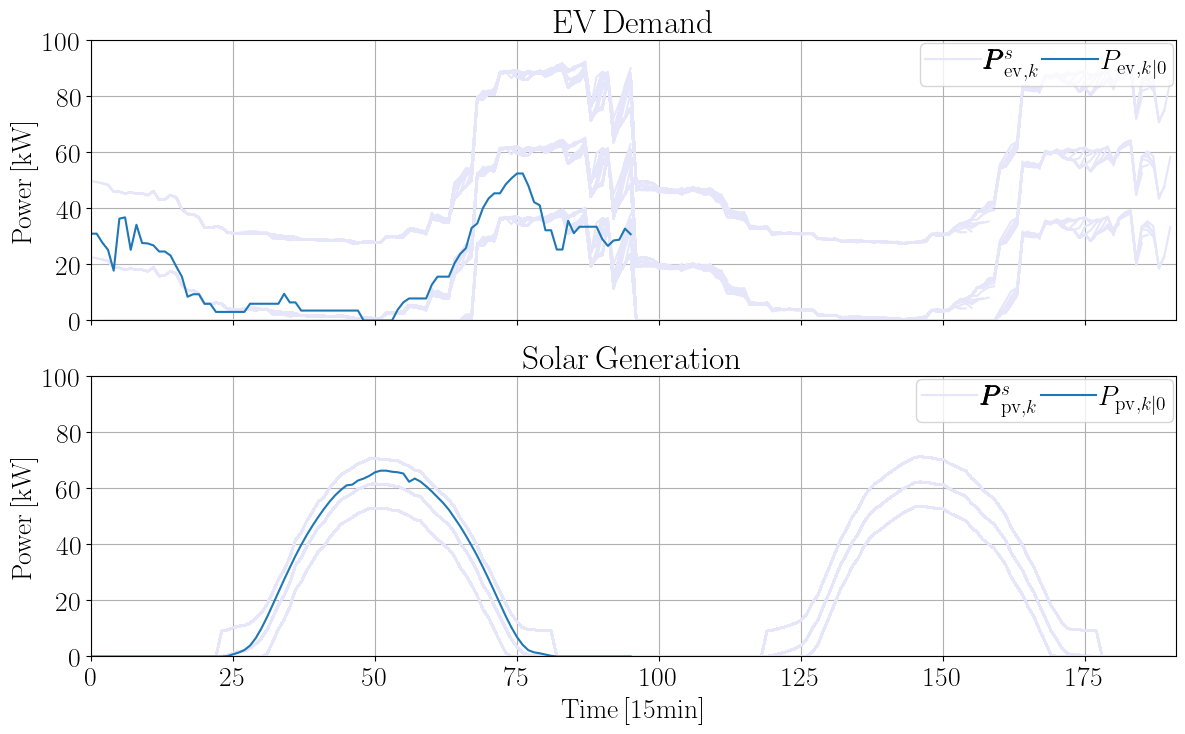

In [33]:
plot_max = 100

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{ev}, k}^s$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA') 
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA') 
        
    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, k|0}$')
    ax[0].set_title(r'$\mathrm{EV\, Demand}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in p_pv_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{pv}, k}^s$')
            ax[1].plot(hours, values[:, 1:], color='#E6E6FA') 
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA') 

    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{pv}, k|0}$')
    ax[1].set_title(r'$\mathrm{Solar \, Generation}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

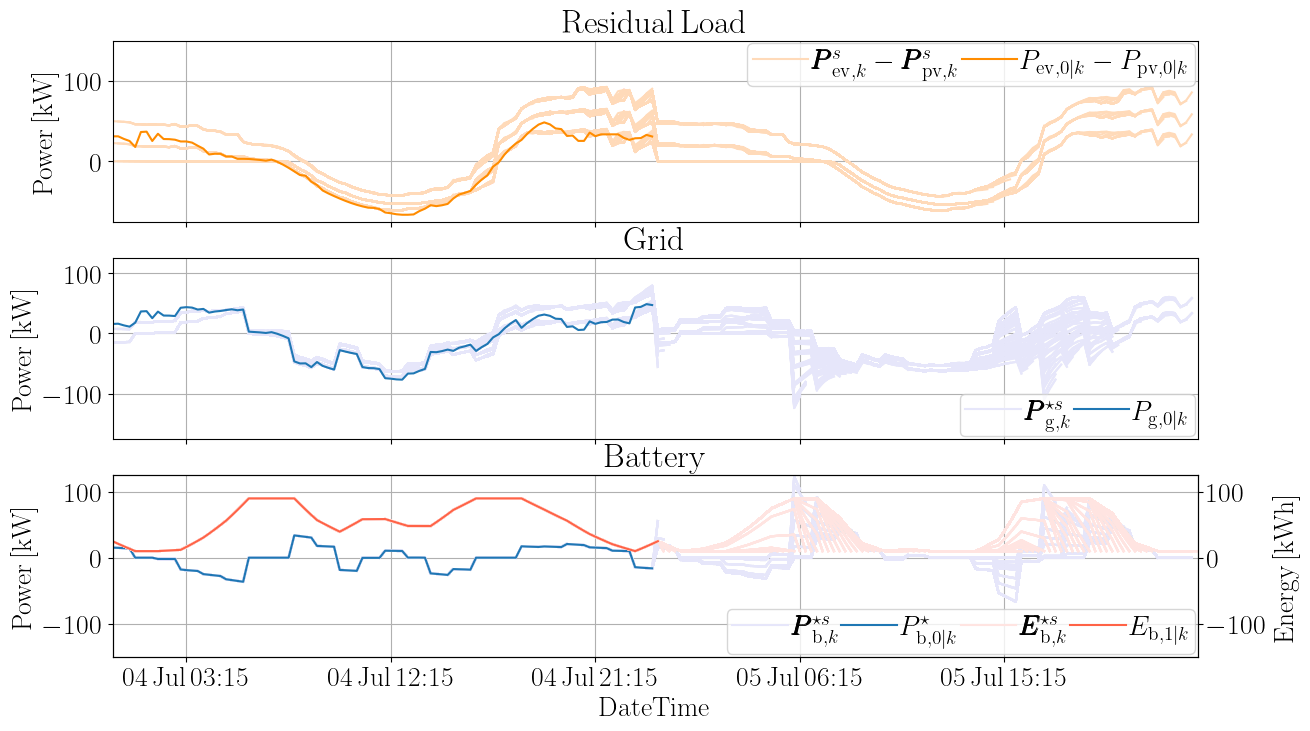

In [34]:
if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#FFDAB9', label=r'$\pmb{P}_{\mathrm{ev}, k}^s - \pmb{P}_{\mathrm{pv}, k}^s$')
            ax[0].plot(hours, power_values[:, 1:], color='#FFDAB9', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, 0|k} - P_{\mathrm{pv}, 0|k}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])
    ax[0].set_xticks(tick_locs)


    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{g}, k}^{\star s}$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_{\mathrm{g}, 0|k}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])
    ax[1].set_xticks(tick_locs)

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{b}, k}^{\star s}$')
            ax[2].plot(dt_eplot[hours], power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', ) 

    ax[2].plot(dt_eplot[0:len(action_real)], action_real_all[e], label=r'$P_{\mathrm{b}, 0|k}^\star$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], energy_values[:, 0], color='mistyrose', label=r'$\pmb{E}_{\mathrm{b}, k}^{\star s}$')
            ax[2].plot(dt_eplot[hours], energy_values[:, 1:], color='mistyrose') 
        else:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose') 
    ax[2].plot(dt_eplot[0:len(E_b_real)], E_b_real_all[e], label=r'$E_{\mathrm{b}, 1|k}$', color='tomato') # check E_b
    ax2_battery = ax[2].twinx()
    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)
    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{DateTime}$')
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    ax[2].set_xlim(dt_eplot.min(), dt_eplot.max())
    ax[2].set_xticks(dt_eplot[tick_locs])
    ax[2].set_xticklabels([dt.strftime(r'$%d\mathrm{\,%b\,} %H\mathord{:}%M$') for dt in dt_eplot[tick_locs]], ha='center')
    
    # fig.savefig(f'{resFolder}/MPCSce_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCSce_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')


### main plot

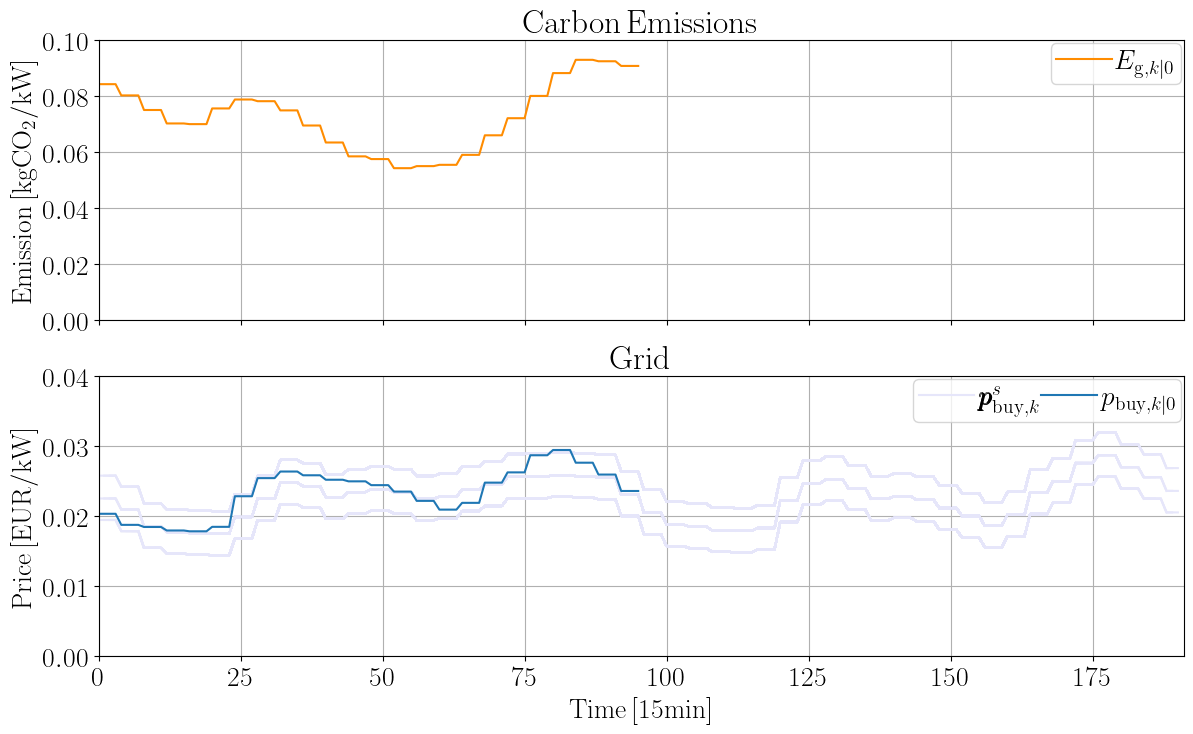

In [35]:
plot_p_max = 0.02 * 2
plot_em_max = 0.02 * 5

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(emission_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$E_{\mathrm{g}, k|0}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Carbon\, Emissions}$')
    ax[0].set_ylabel(r'$\mathrm{Emission \, [kg \mathrm{CO}_2 / kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_em_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in price_buy_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:, 0], color='#E6E6FA', label=r'$\pmb{p}_{\mathrm{buy}, k}^s$')
            ax[1].plot(hours, values[:, 1:], color='#E6E6FA') 
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA') 

    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$p_{\mathrm{buy}, k|0}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Price \, [EUR/kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_p_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()

    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

    # fig.savefig(f'Resultsv2/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'Resultsv2/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

## MPC Recourse

In [36]:
agent_config_rec = {
    'version': 'MPCstochv3',
    'alphas': alphas_test,
    'n_eval_episodes_per_season': n_episodes_per_season_test,
    'n_eval_days_per_episode': n_days_per_episode_test,
    'norm_E_b_zero': 100 * scale_bat, # kWh
    'norm_p_zero': 100, # kW
    'norm_p_sc_zero': 1000 * scale_bat, # kW
    'norm_cost_zero': 1,
}

In [37]:
do_print_steps = False
do_save_agent = do_save_env = saveVarsEnvAgent_plot
env = EHv2(battery_config=battery_config_opt_v4, agent_config=agent_config_rec, do_save_env_vars=do_save_env)
agent = MPCstochv3week(env=env, agent_config=agent_config_rec, do_save_agent_vars=do_save_agent)

reward_all = np.zeros(env.n_episodes)
emission_all = np.zeros(env.n_episodes)
E_b_real_all = {}
action_real_all = {}

p_g_all = {}
p_b_all = {}
p_i_all = {}
E_b_all = {}
res_load_all = {}
p_ev_all = {}
p_pv_all = {}
price_buy_all = {}
price_sell_all = {}

grid_actual_all = {}
reward_actual_all = {}
emission_actual_all = {}
load_actual_all = {}
pv_actual_all = {}
price_actual_all = {}

for e in range(env.n_episodes):
    print('------------------------------ EpisodeId: %r (SeasonId: %r, SeasonEpId: %r) ------------------------------' %(env.episode_id, env.season_id, env.season_episode_id))
    obs, _ = env.reset()
    if do_save_agent:
        agent = MPCstochv3week(env=env, agent_config=agent_config_rec, do_save_agent_vars=do_save_agent)
    episode_reward = episode_emissions = 0
    done = False
    E_b_real = np.zeros((env.horizon_optimization * env.n_days_per_episode) + 1)
    action_real = np.zeros((env.horizon_optimization * env.n_days_per_episode))

    while not done:
        E_b_real[env.time_k] = obs
        a = agent.act(env=env, verbose=False)
        action_real[env.time_k] = a
        obs, rew, done, _, _ = env.step(action=a)
        if do_print_steps:
            mssg = f" P_b({env.time_k - 1}): {a:.1f}  E_b({env.time_k}): {obs:.1f}  Cost_g({env.time_k - 1}): {rew[0]:.3f} Emission_g({env.time_k - 1}): {rew[1]:.3f}"
            print(mssg)
        episode_reward += rew[0]
        episode_emissions += rew[1]
        
    E_b_real[env.time_k + 1] = obs 

    reward_all[e] = episode_reward
    emission_all[e] = episode_emissions
    E_b_real_all[e] = E_b_real
    action_real_all[e] = action_real

    if do_save_agent:
        p_g_all[e] = agent.p_g
        p_b_all[e] = agent.p_b
        p_i_all[e] = agent.p_i
        E_b_all[e] = agent.E_b
        res_load_all[e] = agent.res_load
        p_ev_all[e] = agent.ev
        p_pv_all[e] = agent.pv
        price_buy_all[e] = agent.price_buy
        price_sell_all[e] = agent.price_sell

    if do_save_env:
        grid_actual_all[e] = env.grid_actual_save
        reward_actual_all[e] = env.reward_actual_save
        load_actual_all[e] = env.load_actual_save
        pv_actual_all[e] = env.pv_actual_save
        price_actual_all[e] = env.price_actual_save
        emission_actual_all[e] = env.emission_actual_save


------------------------------ EpisodeId: 0 (SeasonId: 0, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 1 (SeasonId: 0, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 2 (SeasonId: 0, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 3 (SeasonId: 0, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 4 (SeasonId: 1, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 5 (SeasonId: 1, SeasonEpId: 1) ------------------------------
------------------------------ EpisodeId: 6 (SeasonId: 1, SeasonEpId: 2) ------------------------------
------------------------------ EpisodeId: 7 (SeasonId: 1, SeasonEpId: 3) ------------------------------
------------------------------ EpisodeId: 8 (SeasonId: 2, SeasonEpId: 0) ------------------------------
------------------------------ EpisodeId: 9 (SeasonId: 2, Season

In [38]:
reward_all_stoch_rec = reward_all
emission_all_stoch_rec = emission_all

In [39]:
e = e_plot
reward_all_stoch_rec[e], emission_all_stoch_rec[e]

(np.float64(-9.506859497065406), np.float64(9.762133874587153))

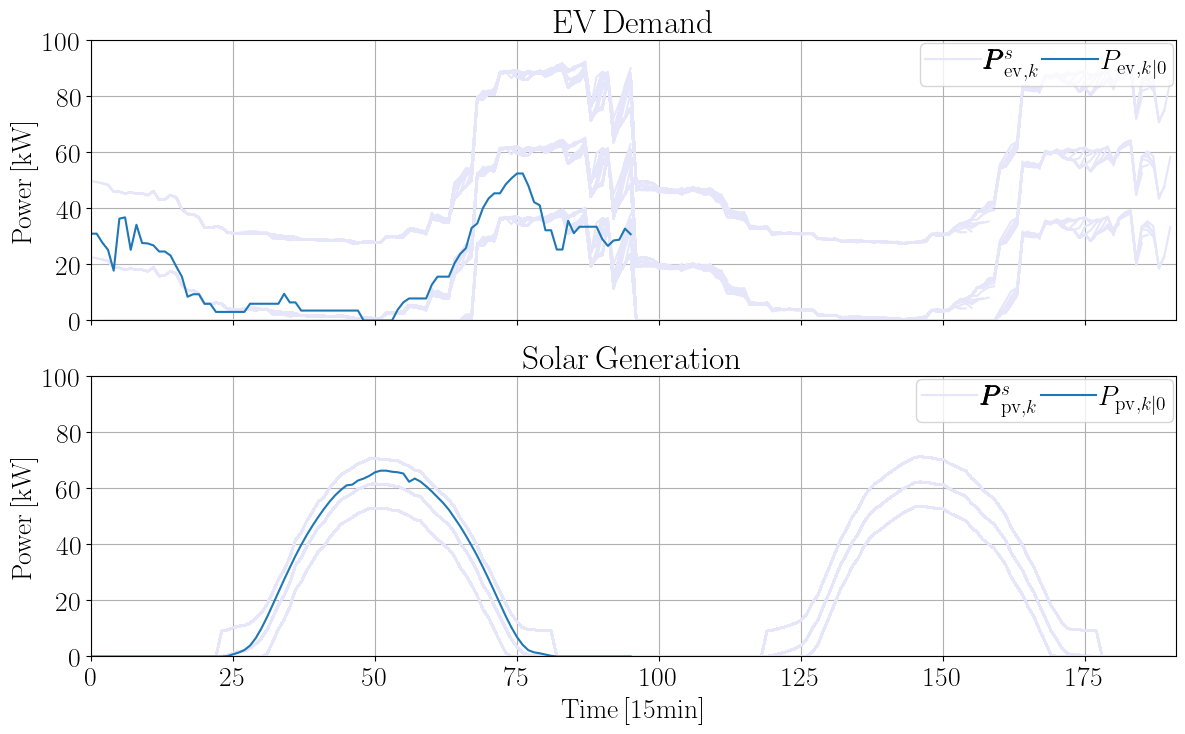

In [40]:
plot_max = 100

if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    for start_hour, power_values in p_ev_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{ev}, k}^s$')
            ax[0].plot(hours, power_values[:, 1:], color='#E6E6FA') 
        else:
            ax[0].plot(hours, power_values[:], color='#E6E6FA') 
        
    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, k|0}$')
    ax[0].set_title(r'$\mathrm{EV\, Demand}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in p_pv_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{pv}, k}^s$')
            ax[1].plot(hours, values[:, 1:], color='#E6E6FA') 
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA') 

    ax[1].plot(range(96*n_days_per_episode_test), pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{pv}, k|0}$')
    ax[1].set_title(r'$\mathrm{Solar \, Generation}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

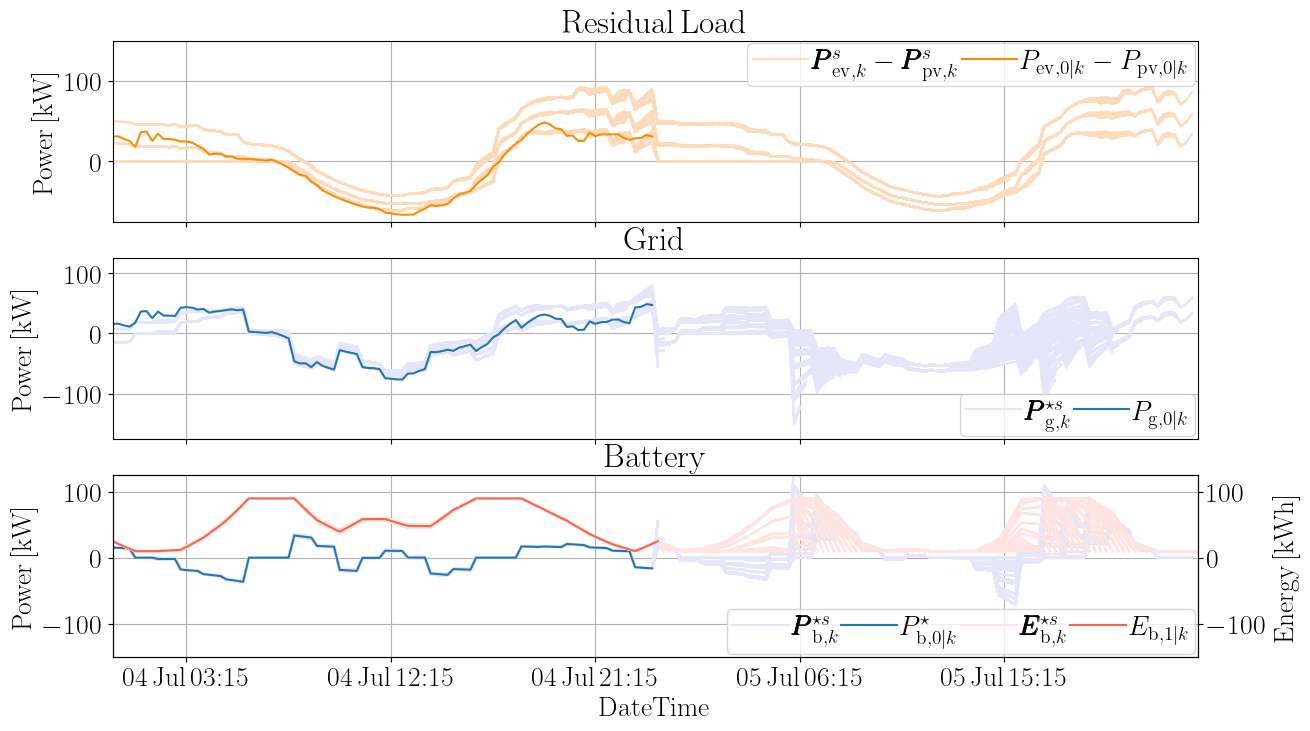

In [41]:
if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(3, 1, figsize=(14, 8))

    for start_hour, power_values in res_load_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[0].plot(hours, power_values[:, 0], color='#FFDAB9', label=r'$\pmb{P}_{\mathrm{ev}, k}^s - \pmb{P}_{\mathrm{pv}, k}^s$')
            ax[0].plot(hours, power_values[:, 1:], color='#FFDAB9', ) 
        else:
            ax[0].plot(hours, power_values[:], color='#FFDAB9', ) 

    ax[0].plot(range(96*n_days_per_episode_test), load_actual_all[e][0:0+96*n_days_per_episode_test] - pv_actual_all[e][0:0+96*n_days_per_episode_test], label=r'$P_{\mathrm{ev}, 0|k} - P_{\mathrm{pv}, 0|k}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Residual \, Load}$')
    ax[0].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[0].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(plot_power_min, plot_power_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])
    ax[0].set_xticks(tick_locs)

    for start_hour, power_values in p_g_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0: 
            ax[1].plot(hours, power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{g}, k}^{\star s}$')
            ax[1].plot(hours, power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[1].plot(hours, power_values[:], color='#E6E6FA', ) 
    ax[1].plot(range(96*n_days_per_episode_test), grid_actual_all[e], label=r'$P_{\mathrm{g}, 0|k}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(plot_grid_min, plot_grid_max)
    ax[1].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()
    ax[1].set_xticklabels([])
    ax[1].set_xticks(tick_locs)

    for start_hour, power_values in p_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], power_values[:, 0], color='#E6E6FA', label=r'$\pmb{P}_{\mathrm{b}, k}^{\star s}$')
            ax[2].plot(dt_eplot[hours], power_values[:, 1:], color='#E6E6FA', ) 
        else:
            ax[2].plot(dt_eplot[hours], power_values[:], color='#E6E6FA', ) 

    ax[2].plot(dt_eplot[0:len(action_real)], action_real_all[e], label=r'$P_{\mathrm{b}, 0|k}^\star$')

    for start_hour, energy_values in E_b_all[e].items():
        hours = np.arange(start_hour, start_hour + env.horizon_optimization + 1)
        if start_hour == 0:
            ax[2].plot(dt_eplot[hours], energy_values[:, 0], color='mistyrose', label=r'$\pmb{E}_{\mathrm{b}, k}^{\star s}$')
            ax[2].plot(dt_eplot[hours], energy_values[:, 1:], color='mistyrose') 
        else:
            ax[2].plot(dt_eplot[hours], energy_values[:], color='mistyrose') 

    ax[2].plot(dt_eplot[0:len(E_b_real)], E_b_real_all[e], label=r'$E_{\mathrm{b}, 1|k}$', color='tomato') # check E_b

    ax2_battery = ax[2].twinx()
    ax2_battery.set_ylabel(r'$\mathrm{Energy \, [kWh]}$')  # Label for the second y-axis
    ax2_battery.set_ylim(plot_bat_min, plot_bat_max)

    ax[2].set_title(r'$\mathrm{Battery}$')
    ax[2].set_ylabel(r'$\mathrm{Power \, [kW]}$')
    ax[2].set_xlabel(r'$\mathrm{DateTime}$')
    ax[2].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[2].set_ylim(plot_bat_min, plot_bat_max)
    ax[2].legend(loc='lower right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[2].grid()
    ax[2].set_xlim(dt_eplot.min(), dt_eplot.max())
    ax[2].set_xticks(dt_eplot[tick_locs])
    ax[2].set_xticklabels([dt.strftime(r'$%d\mathrm{\,%b\,} %H\mathord{:}%M$') for dt in dt_eplot[tick_locs]], ha='center')

    # fig.savefig(f'{resFolder}/MPCRec_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'{resFolder}/MPCRec_{n_episodes_per_season_test*n_days_per_episode_test}days_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')
    

### main plot

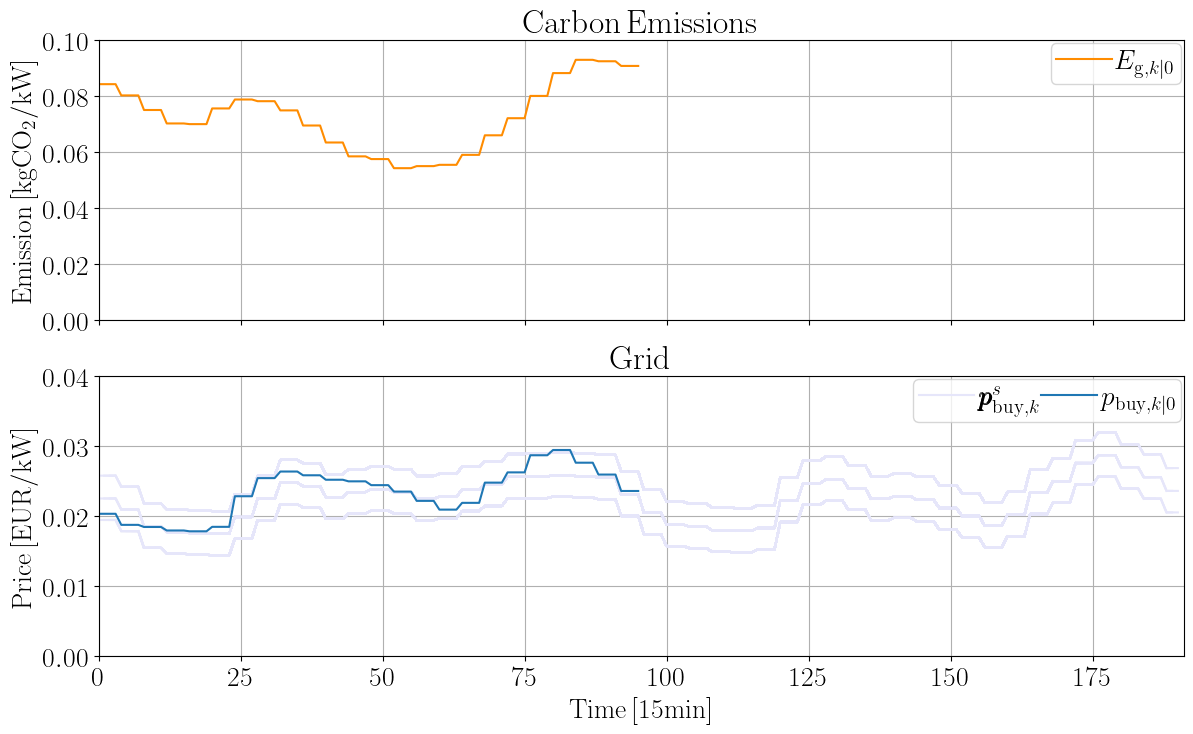

In [42]:
plot_p_max = 0.02 * 2
plot_em_max = 0.02 * 5


if saveVarsEnvAgent_plot:
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    ax[0].plot(range(96*n_days_per_episode_test), np.repeat(emission_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$E_{\mathrm{g}, k|0}$', color='darkorange')
    ax[0].set_title(r'$\mathrm{Carbon\, Emissions}$')
    ax[0].set_ylabel(r'$\mathrm{Emission \, [kg \mathrm{CO}_2 / kW]}$')
    ax[0].set_xlim(0, 96*(n_days_per_episode_test+1)-1)
    ax[0].set_ylim(0, plot_em_max)
    ax[0].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[0].grid()
    ax[0].set_xticklabels([])

    for start, values in price_buy_all[e].items():
        hours = np.arange(start, start + env.horizon_optimization)
        if start == 0: 
            ax[1].plot(hours, values[:, 0], color='#E6E6FA', label=r'$\pmb{p}_{\mathrm{buy}, k}^s$')
            ax[1].plot(hours, values[:, 1:], color='#E6E6FA') 
        else:
            ax[1].plot(hours, values[:], color='#E6E6FA') 

    ax[1].plot(range(96*n_days_per_episode_test), np.repeat(price_actual_all[e], 4)[0:0+96*n_days_per_episode_test], label=r'$p_{\mathrm{buy}, k|0}$')
    ax[1].set_title(r'$\mathrm{Grid}$')
    ax[1].set_ylabel(r'$\mathrm{Price \, [EUR/kW]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)
    ax[1].set_ylim(0, plot_p_max)
    ax[1].legend(loc='upper right', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, borderaxespad=0.1, fontsize=20)
    ax[1].grid()

    ax[1].set_xlabel(r'$\mathrm{Time \, [15min]}$')
    ax[1].set_xlim(0,96*(n_days_per_episode_test+1)-1)

    # fig.savefig(f'Resultsv2/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.svg', format='svg', dpi=300, bbox_inches='tight')
    # fig.savefig(f'Resultsv2/MPCOmn_{4*n_days_per_season_test}daysSeason_ep{e}.eps', format='eps', dpi=300, bbox_inches='tight')

<!-- ### plot results -->

## Comparison

In [62]:
runtimeScenario = 208
runtimeRec = 169
runtimeVan = 90
runtimeOmn = 12
print(f"Time per episode \n Omn MPC: {runtimeOmn / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Vanilla MPC: {runtimeVan / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Scenario MPC: {runtimeScenario / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins \n Recourse MPC: {runtimeRec / (n_episodes_per_season_test * n_days_per_episode_test * 4):.4f} mins")
print(f"Diff per episode \n Omn MPC: {(runtimeOmn) / runtimeScenario:.4f} \n Vanilla MPC: {(runtimeVan) / (runtimeScenario):.4f} \n Scenario MPC: {(runtimeScenario) / (runtimeScenario):.4f} \n Recourse MPC: {runtimeRec / (runtimeScenario):.4f} ")

Time per episode 
 Omn MPC: 0.7500 mins 
 Vanilla MPC: 5.6250 mins 
 Scenario MPC: 13.0000 mins 
 Recourse MPC: 10.5625 mins
Diff per episode 
 Omn MPC: 0.0577 
 Vanilla MPC: 0.4327 
 Scenario MPC: 1.0000 
 Recourse MPC: 0.8125 


In [44]:
rewards_df = pd.DataFrame({
                            'omn': reward_all_det_omn,
                            'vanilla': reward_all_det_van,
                            'scenario': reward_all_stoch,
                            'recourse': reward_all_stoch_rec,
                        })

In [45]:
emissions_df = pd.DataFrame({
                            'omn': emission_all_det_omn,
                            'vanilla': emission_all_det_van,
                            'scenario': emission_all_stoch,
                            'recourse': emission_all_stoch_rec,
                        })

In [46]:
# rewards_df = pd.read_csv(f'{resFolder}/280days_1alphas_2021price_20250605.csv', index_col=0)
# emissions_df = pd.read_csv(f'{resFolder}/280days_1alphas_2021emission_20250605.csv', index_col=0)

In [47]:
# cols = ['omn', 'vanilla', 'scenario', 'recourse']
# rewards_df[cols] = rewards_df[cols].div(np.abs(rewards_df['omn']), axis=0)
# rewards_df.round(3)

In [48]:
season_mapping = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
rewards_df['season'] = pd.Series((np.arange(len(rewards_df)) // (n_episodes_per_season_test)).astype(int)).map(season_mapping)
emissions_df['season'] = pd.Series((np.arange(len(emissions_df)) // (n_episodes_per_season_test)).astype(int)).map(season_mapping)

In [49]:
rewards_df.round(3)

,omn,vanilla,scenario,recourse,season
0,41.457,42.202,42.187,42.186,winter
1,11.803,13.992,13.918,13.929,winter
2,8.960,9.893,10.031,10.030,winter
3,18.726,20.140,19.580,19.579,winter
4,2.082,4.460,4.216,4.213,spring
5,20.793,23.037,23.075,23.077,spring
6,6.713,7.176,7.064,7.037,spring
7,-3.075,-1.894,-1.806,-1.804,spring
8,2.757,3.086,3.131,3.131,summer
9,32.768,33.206,33.222,33.222,summer


In [50]:
emissions_df.round(3)

,omn,vanilla,scenario,recourse,season
0,296.836,298.981,299.468,299.458,winter
1,110.505,109.948,110.304,110.312,winter
2,61.262,63.218,63.615,63.610,winter
3,140.459,139.404,139.262,139.261,winter
4,45.880,41.730,42.339,42.329,spring
5,113.786,118.335,117.181,117.193,spring
6,9.601,11.188,11.746,11.798,spring
7,-16.318,-19.284,-19.263,-19.182,spring
8,37.418,37.445,36.933,36.932,summer
9,141.756,142.812,143.228,143.228,summer


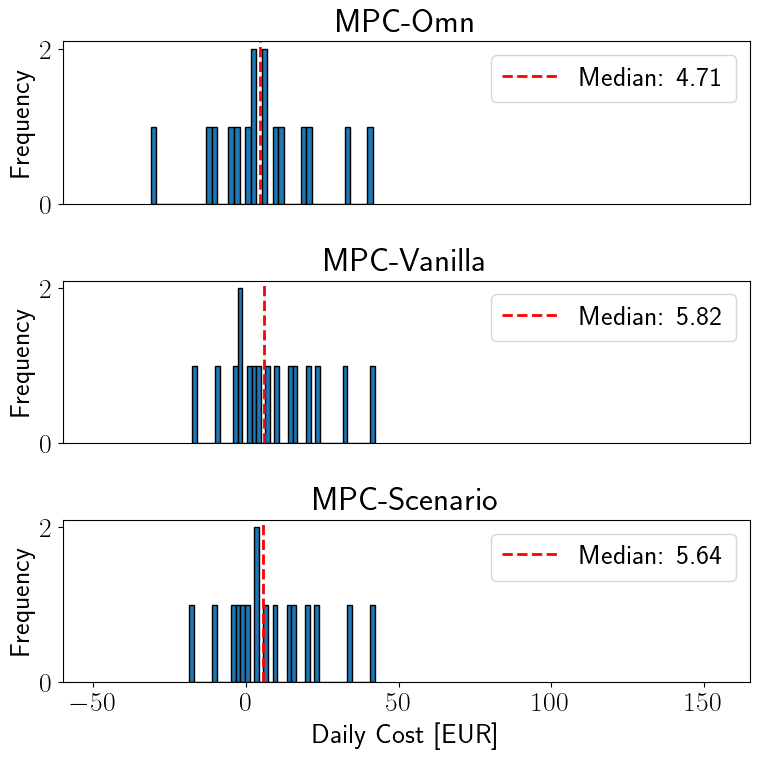

In [51]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))

for ax, col in zip(axes, ['omn', 'vanilla', 'scenario']):
    data = rewards_df[col]
    ax.hist(data, bins=40, color='C0', edgecolor='black')
    med = data.median()
    ax.axvline(med, color='red', linestyle='--', linewidth=2, 
               label=f'Median: {med:.2f}')
    ax.set_title(f"MPC-{col.capitalize()}")
    ax.set_ylabel("Frequency")
    ax.set_xlim(-60, 165)
    
    if ax is axes[-1]:
        ax.set_xlabel("Daily Cost [EUR]")
    else:
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    ax.legend()

plt.tight_layout()
plt.show()

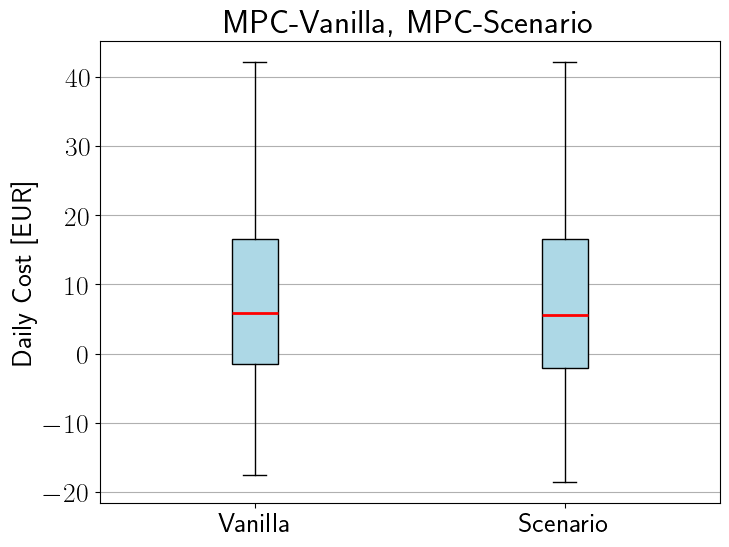

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([rewards_df['vanilla'], rewards_df['scenario']],
           labels=['Vanilla', 'Scenario'],
           patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='red', linewidth=2))

ax.set_ylabel("Daily Cost [EUR]")
ax.set_title("MPC-Vanilla, MPC-Scenario")
plt.grid(axis='y')
plt.show()

In [53]:
rewards_df.drop(columns='season').std(axis=0).round(2)

omn         17.55
vanilla     15.57
scenario    15.78
recourse    15.78
dtype: float64

In [54]:
agg1_rewards_df = rewards_df.drop(columns='season').mean(axis=0)
(agg1_rewards_df.div(np.abs(agg1_rewards_df['omn']), axis=0).round(5) - 1).round(4)*100

omn          0.00
vanilla     52.27
scenario    47.66
recourse    47.73
dtype: float64

In [55]:
agg1_emissions_df = emissions_df.drop(columns='season').mean(axis=0)
(agg1_emissions_df.div(np.abs(agg1_emissions_df['omn']), axis=0).round(5) - 1).round(4)*100

omn         0.00
vanilla     3.02
scenario    2.28
recourse    2.31
dtype: float64

In [56]:
rewards_df.groupby('season').agg(['mean']).round(2)

,omn,vanilla,scenario,recourse
,mean,mean,mean,mean
season,,,,
autumn,-10.29,-1.89,-2.62,-2.60
spring,6.63,8.19,8.14,8.13
summer,6.28,6.95,6.81,6.81
winter,20.24,21.56,21.43,21.43


In [57]:
emissions_df.groupby('season').agg(['mean']).round(2)

,omn,vanilla,scenario,recourse
,mean,mean,mean,mean
season,,,,
autumn,34.34,42.38,41.28,41.34
spring,38.24,37.99,38.00,38.03
summer,57.77,57.88,56.62,56.62
winter,152.27,152.89,153.16,153.16


In [58]:
agg3_rewards_df = rewards_df.groupby('season').agg(['mean'])
(agg3_rewards_df.div(np.abs(agg3_rewards_df[('omn', 'mean')]), axis=0).round(5) - 1).round(4)*100

,omn,vanilla,scenario,recourse
,mean,mean,mean,mean
season,,,,
autumn,-200.0,-118.39,-125.43,-125.25
spring,0.0,23.64,22.76,22.67
summer,0.0,10.55,8.29,8.29
winter,0.0,6.52,5.89,5.90


In [59]:
agg3_emissions_df = emissions_df.groupby('season').agg(['mean'])
(agg3_emissions_df.div(np.abs(agg3_emissions_df[('omn', 'mean')]), axis=0).round(5) - 1).round(4)*100

,omn,vanilla,scenario,recourse
,mean,mean,mean,mean
season,,,,
autumn,0.0,23.41,20.19,20.37
spring,0.0,-0.64,-0.62,-0.53
summer,0.0,0.20,-1.99,-1.99
winter,0.0,0.41,0.59,0.59


In [60]:
if not saveVarsEnvAgent_plot:
    rewards_df.to_csv(f'{resFolder}/{np.int64((n_episodes_per_season_test*n_days_per_episode_test)*4)}days_{len(alphas_test)}alphas_{env.priceYearTest}price.csv')
    emissions_df.to_csv(f'{resFolder}/{np.int64((n_episodes_per_season_test*n_days_per_episode_test)*4)}days_{len(alphas_test)}alphas_{env.priceYearTest}emission.csv')